<a href="https://colab.research.google.com/github/Maryam101/Biomedical-Image-Processing/blob/main/Copy_of_Biomedical_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3.  Classification

In [ ]:
!unzip -q "/content/Brain tumor (2).zip"

In [ ]:
#imports
import os
import cv2
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm
import albumentations as A


In [ ]:
#create the testset
  
# Directory
directory = "TEST"
  
# Parent Directory path
parent_dir = "/content/Brain tumor"
  
# Path
path = os.path.join(parent_dir, directory)
  
os.mkdir(path)
print("Directory '% s' created" % directory)

#create the Validation  
# Directory
directory = "Validation"
  
# Parent Directory path
parent_dir = "/content/Brain tumor"
  
# Path
path = os.path.join(parent_dir, directory)
  
os.mkdir(path)
print("Directory '% s' created" % directory)

Directory 'TEST' created
Directory 'Validation' created


In [ ]:
MODEL_NAME = 'Brain_tumor_detection'

TRAIN_DIR=["/content/Brain tumor/brain_tumor_dataset/yes", "/content/Brain tumor/brain_tumor_dataset/no"]
VALID_DIR="/content/Brain tumor/Validation"

img_size=224
lr=3e-5

#Count the number of images in each class
for dir_path in TRAIN_DIR:
  count=len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
  if dir_path == TRAIN_DIR[0]:
    print("Yes:", count)
  else:
    print("No:", count)  

Yes: 155
No: 98


In [ ]:
#Splitting Data
#Create Test Set
# 10% images from each class are moved to Test folder 
import shutil

# absolute path
src_path1 = r"/content/Brain tumor/brain_tumor_dataset/yes"
src_path2 = r"/content/Brain tumor/brain_tumor_dataset/no"
dst_path = r'/content/Brain tumor/TEST'


YES= os.listdir(src_path1)
NO = os.listdir(src_path2)

#Moving Yes
for i in range (0, 14):      
      file_name= YES[i]
      # construct full file path
      source = src_path1 + '/'+file_name
      destination = dst_path  +'/'+file_name
      # move only files
      if os.path.isfile(source):
        shutil.move(source, destination)

#Moving NO
for i in range (0, 8):      
      file_name= NO[i]
      # construct full file path
      source = src_path2 + '/'+file_name
      destination = dst_path+ '/'+file_name

      # move only files
      if os.path.isfile(source):
          shutil.move(source, destination)
        
TEST=os.listdir(dst_path)
print("Test length: ",len(TEST))

#Create Validation Set
# Moving 20% of images in each class to Validation Folder 
# absolute path
src_path1 = r"/content/Brain tumor/brain_tumor_dataset/yes"
src_path2 = r"/content/Brain tumor/brain_tumor_dataset/no"
dst_path = r"/content/Brain tumor/Validation"


YES = os.listdir(src_path1)
NO = os.listdir(src_path2)

for i in range (0, 30):      
      file_name= YES[i]
      # construct full file path
      source = src_path1 + '/'+file_name
      destination = dst_path  +'/'+file_name
      # move only files
      if os.path.isfile(source):
        shutil.move(source, destination)

for i in range (0, 19):      
      file_name= NO[i]
      # construct full file path
      source = src_path2 + '/'+file_name
      destination = dst_path+ '/'+file_name

      # move only files
      if os.path.isfile(source):
          shutil.move(source, destination)
        

validation=os.listdir(dst_path)
print("Validation length: ",len(validation))

Test length:  22
Validation length:  49


In [ ]:
#Preprocessing
#Augmentation
path = r"/content/Brain tumor/brain_tumor_dataset/yes"

num_images = 300

# Define the augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.5)
])

images = []
for i in os.listdir(path):
    img = cv2.imread(os.path.join(path, i))#
    images.append(img)

while len(images) < num_images:
    aug_data = transform(image=images[np.random.randint(len(images))]) 
    print(aug_data)
    aug_img = aug_data['image']
    images.append(aug_img)

print(len(images))

for i in range(len(images)):
    aug_img = images[i ]
    cv2.imwrite(os.path.join(path, f"aug_{i}YES.JPG"), aug_img)

633


In [ ]:
#Preprocessing
#Augmentation
path = r"/content/Brain tumor/brain_tumor_dataset/no"

num_images = 310

# Define the augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.5)
])

images = []
for i in os.listdir(path):
    img = cv2.imread(os.path.join(path, i))
    images.append(img)

while len(images) < num_images:
    aug_data = transform(image=images[np.random.randint(len(images))])
    aug_img = aug_data['image']
    images.append(aug_img)

print(len(images))

for i in range(len(images)):
    aug_img = images[i ]
    cv2.imwrite(os.path.join(path, f"aug_{i}NO.JPG"), aug_img)

In [ ]:
def create_label(directory):
    if directory == TRAIN_DIR[0]:
        return np.array([1,0]) # YES
    elif directory == TRAIN_DIR[1]:
        return np.array([0,1]) # NO
    elif directory[32]=="Y":
        return np.array([1,0])
    elif directory[32]=="N":
        return np.array([0,1])

def create_train_data():
  training_data = []
  for i in range(len(TRAIN_DIR)):
        for img in tqdm(os.listdir(TRAIN_DIR[i])[:]):
            path = os.path.join(TRAIN_DIR[i], img)
            img_data = cv2.imread(path, 0)
            img_data = cv2.resize(img_data, (img_size, img_size))
            label=create_label(TRAIN_DIR[i])
            training_data.append((img_data, label))       
  shuffle(training_data)
  np.save('train_data.npy', training_data)
  return np.array(training_data)


def create_validation_data():
    validation_data = []
    for img in tqdm(os.listdir(VALID_DIR)):
        path = os.path.join(VALID_DIR, img)
        img_data = cv2.imread(path, 0)
        img_data = cv2.resize(img_data, (img_size, img_size))
        label = create_label(path)  # Pass the directory to create_label()
        validation_data.append((img_data, label))
    shuffle(validation_data)
    np.save('validation_data.npy', validation_data)
    return np.array(validation_data)


if (os.path.exists('train_data.npy')):  # If you have already created the dataset:
    train_data = np.load('train_data.npy', allow_pickle=True)

else:
    train_data = create_train_data()

if (os.path.exists('validation_data.npy')):  # If you have already created the dataset:
    validation_data = np.load('validation_data.npy', allow_pickle=True)

else:
    validation_data = create_validation_data()
    

In [ ]:
train=train_data
validation=validation_data

#split img from its label
x_train= np.array([i[0] for i in train]).reshape(-1, img_size, img_size,1)
y_train = [i[1] for i in train]

x_validate= np.array([i[0] for i in validation]).reshape(-1, img_size, img_size,1)
y_validate = [i[1] for i in validation]

x_train = x_train.astype("float32") / 255.0
x_validate = x_validate.astype("float32") / 255.0

X_train = np.stack(x_train).reshape(-1, img_size,img_size, 1)
X_validate = np.stack(x_validate).reshape(-1, img_size, img_size, 1)

y_train = np.stack(y_train).reshape(X_train.shape[0], 2)
y_validate = np.stack(y_validate).reshape(X_validate.shape[0],2)


In [ ]:
from keras import callbacks
import keras
from keras.models import Sequential                        # This gets our neuralnetwork as Sequential network as we know it can be sequential layers or graph.
from tensorflow.keras.layers import Conv2D                 # We are working with images. All the images are basically 2D.
from tensorflow.keras.layers import MaxPooling2D           # We choose max pooling.
from tensorflow.keras.layers import Flatten                # The process of converting all the resultant 2D arrays into a single long continous linear vector.
from tensorflow.keras.layers import Dense                  # The last step! The full connection of the neural network is performed with this Dense.
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

#Defining input image shape
_input = Input((img_size, img_size,1))

#Building VGG-16 Model
conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(_input)
conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv1)
pool1  = MaxPooling2D((2, 2))(conv2)

conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv3)
pool2  = MaxPooling2D((2, 2))(conv4)

conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
pool3  = MaxPooling2D((2, 2))(conv7)

conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
pool4  = MaxPooling2D((2, 2))(conv10)

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
pool5  = MaxPooling2D((2, 2))(conv13)

flat   = Flatten()(pool5)
#fully connected layers
dense1 = Dense(4096, activation="relu")(flat)
dense2 = Dense(4096, activation="relu")(dense1)
output = Dense(2, activation="softmax")(dense2)

vgg16_model  = Model(inputs=_input, outputs=output)
vgg16_model.summary()

from keras.optimizers import Adam
opt = Adam(lr=3e-5)
vgg16_model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

from keras.models import load_model
if (os.path.exists('model.tfl')):
    vgg16_model=load_model('./model.tfl')
else:
    # Fit the model using the perturbed data
    vgg16_model.fit( x_train,  y_train,
                    validation_data=(x_validate, y_validate),
                    epochs=30, callbacks=[early_stop],
                    batch_size=32)
    vgg16_model.save('Vgg16_model.tfl')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_26 (Conv2D)          (None, 224, 224, 64)      640       
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 112, 112, 128)     147584    
                                                           

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


6/6 [==============================] - 4s 523ms/step - loss: 0.6921 - accuracy: 0.5714 - val_loss: 0.6873 - val_accuracy: 0.6122
Epoch 2/30
6/6 [==============================] - 3s 479ms/step - loss: 0.6702 - accuracy: 0.6099 - val_loss: 0.6580 - val_accuracy: 0.6122
Epoch 3/30
6/6 [==============================] - 3s 481ms/step - loss: 0.6490 - accuracy: 0.6099 - val_loss: 0.6419 - val_accuracy: 0.6122
Epoch 4/30
6/6 [==============================] - 3s 482ms/step - loss: 0.6349 - accuracy: 0.6154 - val_loss: 0.6212 - val_accuracy: 0.6122
Epoch 5/30
6/6 [==============================] - 3s 471ms/step - loss: 0.5955 - accuracy: 0.6484 - val_loss: 0.5917 - val_accuracy: 0.7143
Epoch 6/30
6/6 [==============================] - 3s 487ms/step - loss: 0.5482 - accuracy: 0.7198 - val_loss: 0.5830 - val_accuracy: 0.7551
Epoch 7/30
6/6 [==============================] - 3s 473ms/step - loss: 0.5481 - accuracy: 0.7473 - val_loss: 0.5611 - val_accuracy: 0.6735
Epoch 8/30
6/6 [===============

2/2 [==============================] - 1s 151ms/step
34
15
49


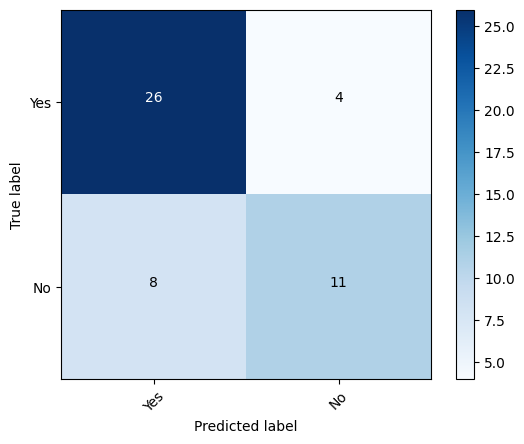

Validation Accuracy: 0.7551020408163265
F1 score: 0.7483493397358945
Recall: 0.7551020408163265
Precision: 0.7525410164065625


In [ ]:
#Model Evaluation
y_pred = vgg16_model.predict(x_validate)
y_pred_classes = np.argmax(y_pred, axis=1)
NO=0
YES=0
for i in y_pred_classes:
  if i==0:
    NO+=1
  else:
    YES+=1
print(NO)
print(YES)  
print(len(y_pred_classes))

#Confusion Matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_validate, axis=1), y_pred_classes)

# Compute the confusion matrix

# Define the class labels
classes = ['Yes', 'No']

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
acc = accuracy_score(np.argmax(y_validate, axis=1), y_pred_classes)
f1 = f1_score(np.argmax(y_validate, axis=1), y_pred_classes, average='weighted')
recall = recall_score(np.argmax(y_validate, axis=1), y_pred_classes, average='weighted')
precision = precision_score(np.argmax(y_validate, axis=1), y_pred_classes, average='weighted')

print('Validation Accuracy:', acc)
print('F1 score:', f1)
print('Recall:', recall)
print('Precision:', precision)

In [ ]:
#Test
from tqdm import tqdm
import pandas as pd
import os
paths = []


Test_Dir='/content/Brain tumor/TEST'
for img in os.listdir(Test_Dir):
    path = os.path.join(Test_Dir, img)
    paths.append(path)

import cv2
names = []
rows = []
NO=0
YES=0
for img in paths:
        label=''
        names.append(img[:])
        path = os.path.join(Test_Dir, img)
        img_data = cv2.imread(path, 0)
        img_data = cv2.resize(img_data, (224, 224))
        img_data = img_data.reshape(224,224,1)
        prediction =vgg16_model.predict(img_data.reshape(-1,224,224,1))[0]
        #print(prediction[:].tolist())
        max_value = max(prediction[:].tolist())
        index = prediction[:].tolist().index(max_value)
        if index == 0:
          label="Yes"
          rows.append("Yes")
            
        else:
            label="No"
            rows.append("No")
        print(img)   
        if img[26]=="Y" and label == "Yes":
          YES+=1
        elif img[26]=="N" and label =="No":
          NO+=1   

dict = {"image_name": names, "label": rows}
df = pd.DataFrame(dict)
print(YES)
print(NO)
# saving the dataframe
df.to_csv('final.csv',index=False)
#14 8

1/1 [==============================] - 0s 33ms/step
/content/Brain tumor/TEST/Y53.jpg
1/1 [==============================] - 0s 33ms/step
/content/Brain tumor/TEST/NO (72).jpg
1/1 [==============================] - 0s 52ms/step
/content/Brain tumor/TEST/Y107.jpg
1/1 [==============================] - 0s 35ms/step
/content/Brain tumor/TEST/Y58.JPG
1/1 [==============================] - 0s 30ms/step
/content/Brain tumor/TEST/NO (91).jpg
1/1 [==============================] - 0s 32ms/step
/content/Brain tumor/TEST/NO (85).jpg
1/1 [==============================] - 0s 29ms/step
/content/Brain tumor/TEST/NO (56).jpg
1/1 [==============================] - 0s 29ms/step
/content/Brain tumor/TEST/Y60.jpg
1/1 [==============================] - 0s 41ms/step
/content/Brain tumor/TEST/Y251.JPG
1/1 [==============================] - 0s 43ms/step
/content/Brain tumor/TEST/NO (74).jpg
1/1 [==============================] - 0s 30ms/step
/content/Brain tumor/TEST/Y34.jpg
1/1 [===========================